In [1]:
!pip install torch

In [2]:
!pip install --upgrade gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 594.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 5.0 MB/s eta 0:00:00


In [3]:
!pip install torch torch-geometric pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00


In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import yfinance as yf

# Step 1: Download and preprocess data
def download_and_preprocess_data(tickers, days=30):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    data = yf.download(tickers, start=start_date, end=end_date)
    df_list = []
    for ticker in tickers:
        df = pd.DataFrame({
            'date': data.index,
            'ticker': ticker,
            'open': data['Open'][ticker],
            'high': data['High'][ticker],
            'low': data['Low'][ticker],
            'close': data['Close'][ticker],
            'volume': data['Volume'][ticker],
            'adj_close': data['Adj Close'][ticker]
        })
        df_list.append(df)

    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df = combined_df.sort_values(['date', 'ticker']).reset_index(drop=True)
    return combined_df

tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "GOOGL", "TSLA", "NVDA", "META", "UNH", "JNJ",
           "V", "JPM", "PG", "HD", "MA", "BAC", "XOM", "CVX", "LLY", "PFE"]

preprocessed_data = download_and_preprocess_data(tickers)

def prepare_for_gnn(df):
    for col in ['open', 'high', 'low', 'close', 'volume', 'adj_close']:
        df[f'{col}_lag1'] = df.groupby('ticker')[col].shift(1)
    df['returns'] = df.groupby('ticker')['adj_close'].pct_change()
    df = df.dropna().reset_index(drop=True)
    return df

gnn_ready_data = prepare_for_gnn(preprocessed_data)
gnn_ready_data.to_csv('gnn_ready_stock_data.csv', index=False)

# Load and preprocess data for GNN input
df = pd.read_csv('gnn_ready_stock_data.csv')

# Define features and target columns
feature_columns = ['open', 'high', 'low', 'close', 'volume', 'adj_close',
                   'open_lag1', 'high_lag1', 'low_lag1', 'close_lag1', 'volume_lag1', 'adj_close_lag1']
target_column = 'returns'

# Normalize features
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Fill NaNs in the target column
df[target_column] = df[target_column].fillna(0)

# Create adjacency matrix based on correlation of returns
tickers = df['ticker'].unique()
corr_matrix = df.pivot(index='date', columns='ticker', values='returns').corr().abs()
adj_matrix = (corr_matrix > 0.5).astype(int)

# Create PyTorch Geometric Data objects
def create_pyg_data(df, adj_matrix, window_size=10):
    data_list = []
    tickers = df['ticker'].unique()
    n_tickers = len(tickers)

    for i in range(window_size, len(df) // n_tickers):
        start_idx = i * n_tickers - window_size
        end_idx = i * n_tickers

        x = torch.FloatTensor(df[feature_columns].values[start_idx:end_idx])
        # Adjusted target to match output size
        y = torch.FloatTensor(df[target_column].values[start_idx:end_idx])

        edge_index = []
        for i in range(n_tickers):
            for j in range(n_tickers):
                if adj_matrix.iloc[i, j] == 1 and i != j:
                    edge_index.append([i, j])

        edge_index = torch.LongTensor(edge_index).t().contiguous()
        max_index = x.size(0) - 1
        edge_index = edge_index[:, (edge_index < max_index).all(0)]

        # Ensure x and y have the same node count
        if x.shape[0] == y.shape[0]:
            data = Data(x=x, y=y, edge_index=edge_index)
            data_list.append(data)

    return data_list

data_list = create_pyg_data(df, adj_matrix)
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Step 3: Define the Temporal GNN model
class TemporalGNN(nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim, num_gcn_layers=2, num_lstm_layers=1):
        super(TemporalGNN, self).__init__()
        self.num_gcn_layers = num_gcn_layers
        self.gcn_layers = nn.ModuleList([GCNConv(num_features if i == 0 else hidden_dim, hidden_dim)
                                         for i in range(num_gcn_layers)])
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch_size = data.num_graphs
        num_nodes = x.size(0) // batch_size

        for i in range(self.num_gcn_layers):
            x = F.relu(self.gcn_layers[i](x, edge_index))

        x = x.view(batch_size, num_nodes, -1)
        x, _ = self.lstm(x)
        x = x.reshape(-1, x.size(-1))
        x = self.fc(x)
        return x.view(-1)

# Step 4: Training loop with debugging
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)

        # Debugging shapes
        print(f"Batch x shape: {batch.x.shape}, edge_index shape: {batch.edge_index.shape}")
        print(f"Model output shape: {out.shape}, Target shape: {batch.y.shape}")

        # Ensure the output and target have the same shape
        if out.shape != batch.y.shape:
            print(f"Shape mismatch: Model output shape {out.shape}, Target shape {batch.y.shape}")
            continue

        loss = criterion(out, batch.y)
        if not torch.isfinite(loss):
            print("Encountered non-finite loss, skipping batch")
            continue

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Instantiate the model, optimizer, and loss function
model = TemporalGNN(num_features=len(feature_columns), hidden_dim=64, output_dim=1, num_gcn_layers=2, num_lstm_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')

[*********************100%***********************]  20 of 20 completed
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Batch x shape: torch.Size([70, 12]), edge_index shape: torch.Size([2, 126])
Model output shape: torch.Size([70]), Target shape: torch.Size([70])
Batch x shape: torch.Size([70, 12]), edge_index shape: torch.Size([2, 126])
Model output shape: torch.Size([70]), Target shape: torch.Size([70])
Batch x shape: torch.Size([70, 12]), edge_index shape: torch.Size([2, 126])
Model output shape: torch.Size([70]), Target shape: torch.Size([70])
Batch x shape: torch.Size([70, 12]), edge_index shape: torch.Size([2, 126])
Model output shape: torch.Size([70]), Target shape: torch.Size([70])
Batch x shape: torch.Size([70, 12]), edge_index shape: torch.Size([2, 126])
Model output shape: torch.Size([70]), Target shape: torch.Size([70])
Batch x shape: torch.Size([70, 12]), edge_index shape: torch.Size([2, 126])
Model output shape: torch.Size([70]), Target shape: torch.Size([70])
Batch x shape: torch.Size([70, 12]), edge_index shape: torch.Size([2, 126])
Model output shape: torch.Size([70]), Target shape: to

In [10]:
def test(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in test_loader:
            out = model(batch)

            # Ensure the output and target have the same shape
            if out.shape != batch.y.shape:
                print(f"Shape mismatch: Model output shape {out.shape}, Target shape {batch.y.shape}")
                continue

            loss = criterion(out, batch.y)
            total_loss += loss.item()

            predictions.extend(out.cpu().numpy())
            actuals.extend(batch.y.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    return avg_loss, predictions, actuals

In [11]:
# Instantiate the model, optimizer, and loss function
model = TemporalGNN(num_features=len(feature_columns), hidden_dim=64, output_dim=1, num_gcn_layers=2, num_lstm_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training and testing the model
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss, predictions, actuals = test(model, test_loader, criterion)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Final evaluation
final_test_loss, final_predictions, final_actuals = test(model, test_loader, criterion)
print(f'Final Test Loss: {final_test_loss:.4f}')

Batch x shape: torch.Size([70, 12]), edge_index shape: torch.Size([2, 126])
Model output shape: torch.Size([70]), Target shape: torch.Size([70])
Batch x shape: torch.Size([70, 12]), edge_index shape: torch.Size([2, 126])
Model output shape: torch.Size([70]), Target shape: torch.Size([70])
Batch x shape: torch.Size([70, 12]), edge_index shape: torch.Size([2, 126])
Model output shape: torch.Size([70]), Target shape: torch.Size([70])
Batch x shape: torch.Size([70, 12]), edge_index shape: torch.Size([2, 126])
Model output shape: torch.Size([70]), Target shape: torch.Size([70])
Batch x shape: torch.Size([70, 12]), edge_index shape: torch.Size([2, 126])
Model output shape: torch.Size([70]), Target shape: torch.Size([70])
Batch x shape: torch.Size([70, 12]), edge_index shape: torch.Size([2, 126])
Model output shape: torch.Size([70]), Target shape: torch.Size([70])
Batch x shape: torch.Size([70, 12]), edge_index shape: torch.Size([2, 126])
Model output shape: torch.Size([70]), Target shape: to

Mean Squared Error: 0.0004
Mean Absolute Error: 0.0155
R-squared Score: -0.4148


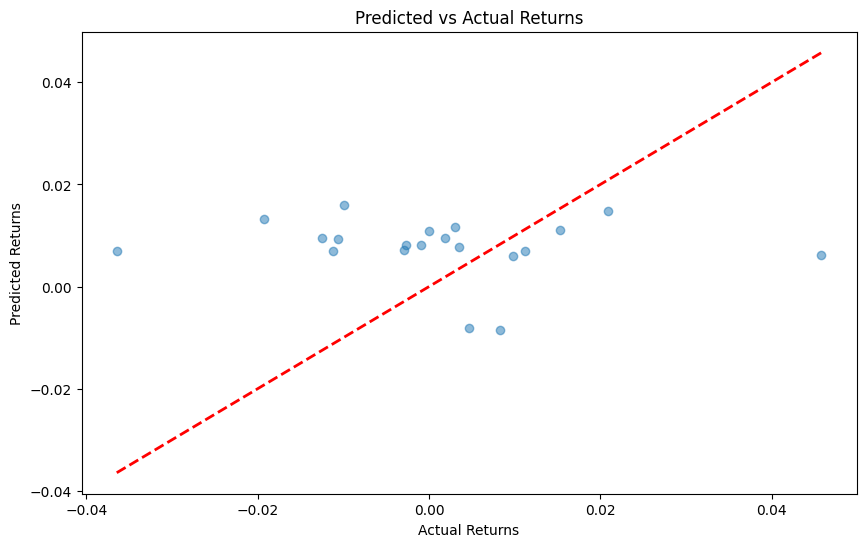

In [12]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Calculate additional metrics
mse = mean_squared_error(final_actuals, final_predictions)
mae = mean_absolute_error(final_actuals, final_predictions)
r2 = r2_score(final_actuals, final_predictions)

print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared Score: {r2:.4f}')

# Visualize predictions vs actuals
plt.figure(figsize=(10, 6))
plt.scatter(final_actuals, final_predictions, alpha=0.5)
plt.plot([min(final_actuals), max(final_actuals)], [min(final_actuals), max(final_actuals)], 'r--', lw=2)
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title('Predicted vs Actual Returns')
plt.show()

Display results


In [ ]:
import gradio as gr